# pyWATVina (Python API for watvina) 教程

## pyWATVina的安装流程：

**pyWATVina的安装较为复杂，请按照以下流程安装** 

1. **解压 pywatvina.zip**

`unzip pywatvina.zip`

2. **解压 pywatvina的静态库**

`cd watvina`

`ar -x libwatvina.a`

该步骤会生成若干的 `.o` 格式的文件

3. **重新编译成动态库，以便python调用**

**注意要在自己python环境下的boost版本 **

`g++ -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 *.o -o _watvina_wrapper.so -lboost_thread -lboost_serialization -lboost_filesystem -lboost_program_options`

该步骤会生成 `_watvina_wrapper.so` 动态库

4. **删除不必要的文件** 

`$rm *.a *.o`

5. **将本文件夹`watvina`拷贝到python环境**

一般是 `${你的python环境下lib/python3.x/dist-pakcages/}`

In [1]:
# Step 1: 加载watvina模块和rdkit2pdbqt.py的函数
from watvina.watvina_wrapper import WATVina
from watvina.rdkit2pdbqt import *

In [2]:
# Step 2: 建立一个对接任务，采用8个cpu核
wv=WATVina(8)

In [3]:
#从pdb文件读取受体
receptor_mol=Chem.MolFromPDBFile("rec.pdb", removeHs=False)
receptor_lines=MolToPDBQTBlock(receptor_mol, False, False, True)
wv.set_receptor_from_string(receptor_lines)

In [4]:
# Step 2.x:  读取水，或者药效团设置
#wv.set_pharmacophore_from_file("pharm.txt")
#wv.set_water("water.pdb",implicitsol=False)

In [5]:
# Step 3: 设置打分权重和格点
wv.set_watvina_weights(weight_vdw=0.193,weight_hb=0.6,weight_elep=0.15)
wv.set_extra_constraints(weight_desol=-0.500, wclash_dist=0.500, weight_torsion=0.300)
wv.set_grid_dims(center_x=0.55,center_y=30,center_z=16.5,size_x=19,size_y=23,size_z=23,granularity=0.5)

In [6]:
#Step 4: 根据打分方程预先计算不同距离的打分, 这个在global_search，score, optimize, relax时候都需要
#不带参数则只储存配体原子类型的格点能量
#wv.set_precalculate_sf()
#watvina的格点能量计算需要点时间, 所以我们如果针对不同的配体最好预先计算所有原子类型
wv.set_precalculate_sf(prec_full_atomtypes=True)

In [7]:
#计算所有原子类型的格点
#后面所有的配体都可以用这一个格点能量，不需要重复计算
%time
wv.compute_watvina_maps()

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 19.8 µs


In [8]:
#Step 5 : 从sdf文件中读取配体
ligand_mol=Chem.MolFromMolFile("i.sdf",removeHs=False)
ligand_lines=MolToPDBQTBlock(ligand_mol, True, False, True)
wv.set_ligand_from_string(ligand_lines)
wv.pose_atomids=[x-1 for x in wv.pose_atomids]
#wv.pose_atomids

In [9]:
#Step 5.x1 只给初始构象打分
wv.score()

-9.984105110168457

In [10]:
#Step 5.x2 只对初始构象进行松弛(relax)
wv.relax_structure(relax_steps=10000, tramplitude=0.001, rotamplitude=1.00)
wv.score()

-9.984105110168457

In [11]:
#Step 5.x3 只对初始构象进行局部优化
wv.optimize(max_steps=100)
wv.score()

-9.917509078979492

In [12]:
#全局搜索构象
%time
wv.global_search(exhaustiveness=12,n_poses=5,min_rmsd=1.5,energy_range=3,population_size=8,
                 ga_searching=4,refinement=True)

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 21.2 µs


In [15]:
print(f'Watvina genetated {len(wv.poses_coords)} conformation.')
print(f'The score of the 1st conformation: {wv.poses_score[0]}')

Watvina genetated 5 conformation.
The score of the 1st conformation: -10.317195892333984


In [13]:
#将对接后的坐标，能量等写入新的构象，并输出文件
#在后面的循环当中，如果只设置conf_w的属性，并不能将属性输出到i_out.sdf文件中，
#如果只设置ligand_mol的属性，最后一个构象缺失属性
from rdkit import Chem
from rdkit.Geometry import Point3D

#print(f'default conformers num: {ligand_mol.GetNumConformers()}')
conf = ligand_mol.GetConformer(0)

writer = Chem.SDWriter('i_out.sdf')
for pose_id in range(len(wv.poses_coords)):
    for atomid,coord in zip(wv.pose_atomids,wv.poses_coords[pose_id]):
        conf.SetAtomPosition(atomid,(coord[0],coord[1],coord[2]))
    #第0个构象是原来的，因此pose_id是0的时候，conf_id是1
    ligand_mol.AddConformer(conf,assignId=True)
    #处理第pose_id + 1的构象
    
    conf_id   = pose_id + 1
    conf_w = ligand_mol.GetConformer(conf_id)
    conf_score='%.2f' % wv.poses_score[pose_id]
    conf_vdw='%.2f' % wv.poses_vdw[pose_id]
    conf_hbond='%.2f' % wv.poses_hbond[pose_id]
    conf_electrop='%.2f' % wv.poses_electrop[pose_id]

    ligand_mol.SetProp('ConfID', f'{conf_id}')
    ligand_mol.SetProp("Score",conf_score)
    ligand_mol.SetProp("VDW",conf_vdw)
    ligand_mol.SetProp("Hbond",conf_hbond)
    ligand_mol.SetProp("Electrop",conf_electrop)
    
    conf_w.SetProp('ConfID', f'{conf_id}')
    conf_w.SetProp("Score",conf_score)
    conf_w.SetProp("VDW",conf_vdw)
    conf_w.SetProp("Hbond",conf_hbond)
    conf_w.SetProp("Electrop",conf_electrop)    
    writer.write(ligand_mol,confId=conf_id)
    #print(f'Processing pose_id {pose_id} and conf_id {conf_id}, and conf real id is {conf_w.GetId()}')

ligand_mol.GetNumConformers()
#ligand_mol.GetConformers()

6

interactive(children=(IntSlider(value=1, description='confId', max=5, min=1), Output()), _dom_classes=('widget…

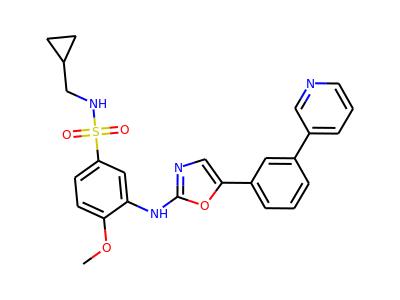

In [14]:
#关于对接后的构象的浏览
import py3Dmol
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from ipywidgets import interact, interactive, fixed

#定义展示分子各个构象的3D结构的函数
def viewlig(ligmol,view3d,confId=-1):
        ligmolblock = Chem.MolToMolBlock(ligmol,confId=confId)
        view3d.removeAllModels()
        view3d.addModel(ligmolblock,'sdf')
        view3d.setStyle({'stick':{}})
        view3d.setBackgroundColor('0xeeeeee')
        view3d.zoomTo()
        return view3d.show()

#交互式展示对接后的构象3D结构
view3d = py3Dmol.view(width=600,height=400)
interact(viewlig, ligmol=fixed(ligand_mol),view3d=fixed(view3d),
         confId=(1,ligand_mol.GetNumConformers()-1));

#展示配体分子2D结构
DrawingOptions.atomLabelFontSize = 80
DrawingOptions.dotsPerAngstrom = 150
DrawingOptions.bondLineWidth = 2.0

ligmol2d = Chem.RemoveHs(ligand_mol)
ligmol2d.RemoveAllConformers()
Draw.MolToImage(ligmol2d, size=(400, 300))

In [15]:
#分析构象1和蛋白的相互作用，该案例用的是prolif
import prolif as plf

protmol_plf = plf.Molecule.from_rdkit(receptor_mol)
ligmol_tmp = Chem.Mol(ligand_mol,confId=1)
ligmol_plf=plf.Molecule.from_rdkit(ligmol_tmp)
fp = plf.Fingerprint()
ifp=fp.generate(ligmol_plf, protmol_plf, return_atoms=True)
ifp["Frame"] = 0
df=plf.to_dataframe([ifp], fp.interactions.keys(), return_atoms=True)
df.T

Frame                                0
ligand protein   interaction          
UNL1   ALA864.A  Hydrophobic   (11, 4)
       ASN921.A  HBAcceptor   (28, 12)
                 VdWContact    (28, 6)
       CYS917.A  HBAcceptor    (10, 6)
                 Hydrophobic    (9, 4)
                 VdWContact     (7, 3)
       GLU883.A  VdWContact    (24, 8)
       GLU915.A  VdWContact    (11, 3)
       GLY920.A  VdWContact     (3, 1)
       LEU1033.A Hydrophobic    (6, 6)
                 VdWContact    (27, 7)
       LEU838.A  Hydrophobic    (2, 7)
       LYS866.A  Hydrophobic   (20, 4)
                 VdWContact    (22, 0)
       LYS918.A  VdWContact     (0, 3)
       PHE1045.A Hydrophobic   (16, 9)
                 PiStacking    (20, 5)
       PHE916.A  Hydrophobic    (2, 8)
                 VdWContact   (10, 12)
       VAL846.A  Hydrophobic   (14, 5)
                 VdWContact   (17, 13)
       VAL912.A  Hydrophobic   (22, 5)
                 VdWContact    (22, 3)
       VAL914.A  Hydrophobic   (18, 6)
                 VdWContact    (21, 6)

In [16]:
#相互作用可视化
from rdkit import Geometry
#下面的函数仅仅是为了计算芳香环，为pi-x stacking 相互作用做准备
def get_ring_centroid(mol, index):
    # find ring using the atom index
    Chem.SanitizeMol(mol, Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
    ri = mol.GetRingInfo()
    for r in ri.AtomRings():
        if index in r:
            break
    else:
        raise ValueError(
            "No ring containing this atom index was found in the given molecule"
        )
    # get centroid
    coords = mol.xyz[list(r)]
    ctd = plf.utils.get_centroid(coords)
    return Geometry.Point3D(*ctd)

In [17]:
import py3Dmol  #前面已经加载过了

colors = {
    "Hydrophobic": "green",
    "HBAcceptor": "cyan",
    "HBDonor": "cyan",
    "XBDonor": "orange",
    "XBAcceptor": "orange",
    "Cationic": "red",
    "Anionic": "blue",
    "PiStacking": "purple",
}

# JavaScript functions
resid_hover = """function(atom,viewer) {{
    if(!atom.label) {{
        atom.label = viewer.addLabel('{0}:'+atom.atom+atom.serial,
            {{position: atom, backgroundColor: 'mintcream', fontColor:'black'}});
    }}
}}"""
hover_func = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.interaction,
            {position: atom, backgroundColor: 'black', fontColor:'white'});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

v = py3Dmol.view(650, 600)
v.removeAllModels()

models = {}
mid = -1
for i, row in df.T.iterrows():
    lresid, presid, interaction = i
    lindex, pindex = row[0]
    #lres = ligmol_plf[lresid]
    lres  = ligmol_plf
    pres = protmol_plf[presid]
    # set model ids for reusing later
    for resid, res, style in [
        (lresid, lres, {"colorscheme": "cyanCarbon"}),
        (presid, pres, {}),
    ]:
        if resid not in models.keys():
            mid += 1
            resnoh=Chem.RemoveAllHs(res) #我这里把氢都删掉了
            v.addModel(Chem.MolToMolBlock(resnoh), "sdf")
            model = v.getModel()
            model.setStyle({}, {"stick": style})
            # add residue label
            model.setHoverable({}, True, resid_hover.format(resid), unhover_func)
            models[resid] = mid
    # get coordinates for both points of the interaction
    if interaction in ["PiStacking", "EdgeToFace", "FaceToFace", "PiCation"]:
        p1 = get_ring_centroid(lres, lindex)
    else:
        p1 = lres.GetConformer().GetAtomPosition(lindex)
    if interaction in ["PiStacking", "EdgeToFace", "FaceToFace", "CationPi"]:
        p2 = get_ring_centroid(pres, pindex)
    else:
        p2 = pres.GetConformer().GetAtomPosition(pindex)
    # add interaction line
    v.addCylinder(
        {
            "start": dict(x=p1.x, y=p1.y, z=p1.z),
            "end": dict(x=p2.x, y=p2.y, z=p2.z),
            "color": colors.get(interaction, "grey"),
            "radius": 0.15,
            "dashed": True,
            "fromCap": 1,
            "toCap": 1,
        }
    )
    # add label when hovering the middle of the dashed line by adding a dummy atom
    c = Geometry.Point3D(*plf.utils.get_centroid([p1, p2]))
    modelID = models[lresid]
    model = v.getModel(modelID)
    model.addAtoms(
        [{"elem": "Z", "x": c.x, "y": c.y, "z": c.z, "interaction": interaction}]
    )
    model.setStyle({"interaction": interaction}, {"clicksphere": {"radius": 0.5}})
    model.setHoverable({"interaction": interaction}, True, hover_func, unhover_func)

# show protein
pmol = Chem.RemoveAllHs(protmol_plf)
pdb = Chem.MolToPDBBlock(pmol, flavor=0x20 | 0x10)
v.addModel(pdb, "pdb")
model = v.getModel()
model.setStyle({}, {"cartoon": {'arrows':False, 'style':'oval',}})

v.zoomTo({"model": list(models.values())})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [18]:
#读取第二个分子
ligand_mol=Chem.MolFromMolFile("2.sdf",removeHs=False)
ligand_lines=MolToPDBQTBlock(ligand_mol, True, False, True)
wv.set_ligand_from_string(ligand_lines)
wv.pose_atomids=[x-1 for x in wv.pose_atomids]
#wv.pose_atomids

In [19]:
#直接全局搜索构象
%time
wv.global_search(exhaustiveness=8,n_poses=9,min_rmsd=1.5,energy_range=3,
                 population_size=8,ga_searching=4,refinement=True)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 19.8 µs


In [20]:
#这个坐标集是第2个分子了
#所有的pose的坐标都保存在wv.poses_coords中
len(wv.poses_coords)

9

In [21]:
#第2个分子对接后构象的打分
#所有pose的打分保存
wv.poses_score

(-8.15003490447998,
 -6.801241874694824,
 -6.120966911315918,
 -6.0618438720703125,
 -5.960515975952148,
 -5.724642753601074,
 -5.633609294891357,
 -5.588569164276123,
 -5.5382843017578125)

In [22]:
#vdw
#所有pose的vdw打分
wv.poses_vdw

(-39.23488998413086,
 -35.50177764892578,
 -31.3544864654541,
 -33.940555572509766,
 -31.576616287231445,
 -32.10298538208008,
 -31.515233993530273,
 -31.110082626342773,
 -29.673877716064453)

In [23]:
#hbond
#所有pose的氢键打分
wv.poses_hbond

(-0.7343505620956421,
 -0.4137977957725525,
 -0.5057589411735535,
 -0.21011140942573547,
 -0.001069774036295712,
 -0.6018202900886536,
 -0.2242744415998459,
 -1.0829895734786987,
 -0.38793709874153137)

In [24]:
#electrop
#所有的pseudo_elec打分
wv.poses_electrop

(-1.678070306777954,
 -1.836064100265503,
 -1.3591662645339966,
 -1.4597786664962769,
 -1.867706537246704,
 -1.8746856451034546,
 -2.0474750995635986,
 -2.2137444019317627,
 -2.100454568862915)

In [25]:
#the rmsd to the initial conformation
wv.poses_rmsdinit

(0.3749750852584839,
 1.8240572214126587,
 4.948639869689941,
 1.9643625020980835,
 2.3377740383148193,
 4.7083048820495605,
 3.656872510910034,
 4.4323649406433105,
 2.330735445022583)